<h1> Demo Notebook</h1>

Notebook for visualising models on a given image.
Given an image and a desired transformation, transform the image given the transformation.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import quaternion
import numpy as np

import os
os.chdir("..")
os.environ['DEBUG'] = '0'

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from models.networks.sync_batchnorm import convert_model
from models.base_model import BaseModel

from options.options import get_model

<h2>Set up the models</h2>

In [6]:
torch.backends.cudnn.enabled = True

# REALESTATE
MODEL_PATH = './modelcheckpoints/realestate/synsin.pth'


BATCH_SIZE = 1

opts = torch.load(MODEL_PATH)['opts']
opts.render_ids = [1]

model = get_model(opts)

torch_devices = [int(gpu_id.strip()) for gpu_id in opts.gpu_ids.split(",")]
device = 'cuda:' + str(torch_devices[0])

if 'sync' in opts.norm_G:
    model = convert_model(model)
    model = nn.DataParallel(model, torch_devices[0:1]).cuda()
else:
    model = nn.DataParallel(model, torch_devices[0:1]).cuda()


#  Load the original model to be tested
model_to_test = BaseModel(model, opts)
model_to_test.load_state_dict(torch.load(MODEL_PATH)['state_dict'])
model_to_test.eval()

print("Loaded model")

Loading model %s ... 
RESNET encoder
RESNET decoder
['1.0_l1', '10.0_content']
Loaded model


<h2> Run the example on an unseen, random image</h2>

In [7]:
from PIL import Image

Max dist:  tensor(0.0010, device='cuda:0') 0.0009765625
Max dist:  tensor(1.0000, device='cuda:0')


Text(0.5, 1.0, 'Predicted Depth')

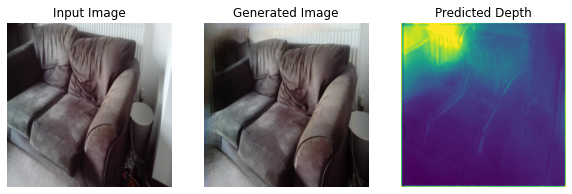

In [8]:
# Load the image
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

im = Image.open('./demos/im.jpg')
im = transform(im)

# Parameters for the transformation
theta = -0.15
phi = -0.1
tx = 0
ty = 0
tz = 0.1

RT = torch.eye(4).unsqueeze(0)
# Set up rotation
RT[0,0:3,0:3] = torch.Tensor(quaternion.as_rotation_matrix(quaternion.from_rotation_vector([phi, theta, 0])))
# Set up translation
RT[0,0:3,3] = torch.Tensor([tx, ty, tz])

batch = {
    'images' : [im.unsqueeze(0)],
    'cameras' : [{
        'K' : torch.eye(4).unsqueeze(0),
        'Kinv' : torch.eye(4).unsqueeze(0)
    }]
}

# Generate a new view at the new transformation
with torch.no_grad():
    pred_imgs = model_to_test.model.module.forward_angle(batch, [RT])
    depth = nn.Sigmoid()(model_to_test.model.module.pts_regressor(batch['images'][0].cuda()))

fig, axis = plt.subplots(1,3, figsize=(10,20))
axis[0].axis('off')
axis[1].axis('off')
axis[2].axis('off')

axis[0].imshow(im.permute(1,2,0) * 0.5 + 0.5)
axis[0].set_title('Input Image')
axis[1].imshow(pred_imgs[0].squeeze().cpu().permute(1,2,0).numpy() * 0.5 + 0.5)
axis[1].set_title('Generated Image')
axis[2].imshow(depth.squeeze().cpu().clamp(max=0.04))
axis[2].set_title('Predicted Depth')